# Power Budget Worksheet

_An estimate of potential running time for this system._


In [2]:
from pathlib import Path
import emoji

IMAGES_PATH = Path() / "images" / "results_and_linear_models"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

print(emoji.emojize(":check_mark_button:"))

✅


### Power Budget

Average Runtime is approx. 57 seconds without modem, and approx. 78 seconds with modem.

- Assuming 100% of battery available:

$ Estimated Battery Life = \frac{(Battery Capacity (mAh)\times100\%)​}{Hourly Consumption (mA)} * (1.0 - BatteryDischargeSafety) $

- Assuming 75% of battery available due to LDO dropoff:

$ Estimated Battery Life = \frac{(Battery Capacity (mAh)\times75\%)​}{Hourly Consumption (mA)} * (1.0 - BatteryDischargeSafety) $

[Battery being tested: XTAR 18650, 2600mAh, 3.7V, 9.62Wh](https://www.xtar.cc/product/xtar-18650-2600mah-battery-69.html)

__There is no data sheet for this specific battery.__

- This table contains integrated components.

* Note: I am assuming, because I am simply powering off the modem using modem.poweroff() [it is a software powerdown], that the modem will continue to leak current. I am not holding PWRKEY low or using any pin manipulation to force a hardware shutoff.

| Mode | Current (mA) | Duration per Run |
| -: | -: | -: |
| Deep Sleep | 0.015mA (worst case) | 21600 sec |
| Active (Measurement Mode, No GSM TX) | 100mA | 80 sec |
| Modem Burst (Peak) | 700mA | 5 sec |
| Modem Transmit | 250mA | 25 sec |
| Modem Sleep | 1mA | 21600 sec | 
| Write to SD Burst | 200mA | 1 sec |
| Write to SD | 100mA | 3 sec |

- This table contains separate components.

| Peripheral | Voltage | Current (mA) |	Active Time (sec/day) |
| -: | -: | -: | -: |
| DFRobot pH Sensor | 3.3V | 4mA |	5 sec |
| Grove TDS Sensor | 3.3V |	4mA	| 5 sec |
| DS18B20 Temp Sensor |	3.3V |	1.5mA |	5 sec |
| RTC Standby |	3.3V | 0.11mA |	21600 sec |
| RTC Active | 3.3V | 0.2mA	| 1 sec |
| ADC PH Active| 3.3V | 0.15mA	| 80 sec |
| ADC TDS Active | 3.3V | 0.15mA | 80 sec |
| ADC PH Standby| 3.3V | 0.15mA	| 21600 sec |
| ADC TDS Standby | 3.3V | 0.15mA| 21600 sec |


__I have run calculations in code blocks below. Here are the results of those calculations.__

```
The total active draw over time for one run is 5.09 mAh.
The total sleep draw over time for one cycle is 8.55 mAh.
The total draw in a 6.02222 hour (one full active and deep sleep) cycle is 13.64 mAh (5.09 mAh + 8.55 mAh).
The average consumption is 2.26 mA.

The estimated "best case" battery life (accounting for 100% charge available, 20% safety margin) is,
918.39 hours, or 38.27 days.
The estimated "likely case" battery life (accounting for 75% charge available, 20% safety margin) is,
688.79 hours, or 28.70 days.

```

In [3]:
# Power Budget Calculator
# current units are in mA
import numpy as np
import matplotlib.pyplot as plt

# define power consumption in mA
deep_sleep = 0.015 # datasheet says 10 μA (0.010 mA), but we will assume 15 μA (0.015 mA)
active_mode = 100 # 100 mA, ESP32 (only) measurement (or "active" mode), when the controller is running
modem_mode_burst = 700 # 700 mA of additional spike when the modem powers up, 100 mA base current already account for
modem_mode = 250 # 250 mA of additional current when the modem is transmitting, 100 mA base current already account for
modem_sleep = 1.0 # 1.0 mA, modem standby current, additional current when the modem is active
storage_mode_burst = 200 # 200 mA of extra current when the SD Card module powers up, 100 mA base current already account for
storage_mode = 100 # 100 mA of extra current when the SD Card module is writing, 100 mA base current already account for
ph_sensor = 4 # 4 mA, pH sensor, additional current when the sensor is active
tds_sensor = 4 # 4 mA, TDS sensor, additional current when the sensor is active
temp_sensor = 1.5 # 1.5 mA, temperature sensor, additional current when the sensor is active
rtc_standby = 0.11 # 0.11 mA, RTC standby current, additional current when the RTC is active
rtc_active = 0.2 # 0.2 mA, RTC active current, additional current when the RTC is active
adc1_active = 0.15 # 0.15 mA, ADC1 active current, additional current when the ADC is active
adc2_active = 0.15 # 0.15 mA, ADC2 active current, additional current when the ADC is active

# We need to define component active times in seconds, totaled for one day
# Overall, we are doing 4 measurements per day, 4 transmissions per day, 4 deep sleep periods per day
# and 4 storage periods per day.
# Let's begin with calculating the time each component is active in one cycle.
active_mode_time = 80 # 80 seconds, ESP32 (only) active mode
modem_mode_burst_time = 5 # 5 seconds, ESP32 (only) transmit mode, when the modem turns on
modem_mode_time = 25 # 25 seconds, ESP32 (only) transmit mode, when the modem is transmitting
storage_mode_burst_time = 1 # 3 seconds, ESP32 (only) storage mode, when the SD Card module turns on
storage_mode_time = 3 # 3 seconds, ESP32 (only) storage mode, when the SD Card module is writing
ph_sensor_time = 5 # 5 seconds, pH sensor active time, sensor is active for ~4-5 seconds per measurement
tds_sensor_time = 5 # 5 seconds, TDS sensor active time, sensor is active for ~4-5 seconds per measurement
temp_sensor_time = 5 # 5 seconds, temperature sensor active time, sensor is active for ~4-5 seconds per measurement
rtc_active_time = 1 # 4 seconds, RTC active time, RTC is active for ~1 second per system run
adc1_active_time = 80 # 80 seconds, ADC1 active time
adc2_active_time = 80 # 80 seconds, ADC2 active time

# These are the deep sleep costs, which are not included in "active time". This is one cycle, lasting 6 hours.
# We are doing 4 deep sleep cycles per day.
deep_sleep_time = 360 * 60 # 21600 seconds, deep sleep time
modem_sleep_time = 360 * 60 # 21600 seconds, modem sleep time
rtc_standby_time = 360 * 60 # 21600 seconds, RTC standby time
adc1_standby_time = 360 * 60 # 21600 seconds, ADC1 standby time
adc2_standby_time = 360 * 60 # 21600 seconds, ADC2 standby time

# Let's print the variables
print('These components are active for "x" seconds per 1 device cycle @ "y" mA.\n',
        '\n',
        
        f'Active mode time: {active_mode_time} seconds @ {active_mode} mA\n',
        f'Transmit mode burst time: {modem_mode_burst_time} seconds @ {modem_mode_burst} mA\n',
        f'Transmit mode time: {modem_mode_time} seconds @ {modem_mode} mA\n',
        f'Storage mode burst time: {storage_mode_burst_time} seconds @ {storage_mode_burst} mA\n',
        f'Storage mode time: {storage_mode_time} seconds @ {storage_mode} mA\n',
        f'pH sensor time: {ph_sensor_time} seconds @ {ph_sensor} mA\n',
        f'TDS sensor time: {tds_sensor_time} seconds @ {tds_sensor} mA\n',
        f'Temperature sensor time: {temp_sensor_time} seconds @ {temp_sensor} mA\n',
        f'RTC active time: {rtc_active_time} seconds @ {rtc_active} mA\n',
        f'ADC1 active time: {adc1_active_time} seconds @ {adc1_active} mA\n',
        f'ADC2 active time: {adc2_active_time} seconds @ {adc2_active} mA\n',
        f'\nThe power draw for "x" seconds per 1 deep sleep cycle @ "y" mA.\n',
        f'Deep sleep time: {deep_sleep_time} seconds ({deep_sleep_time/3600:.2f} hours) @ {deep_sleep} mA\n',
        f'Modem sleep time (software power off): {modem_sleep_time} seconds ({modem_sleep_time/3600:.2f} hours) @ {modem_sleep} mA\n',
        f'RTC standby time: {rtc_standby_time} seconds ({rtc_standby_time/3600:.2f} hours) @ {rtc_standby} mA\n',
        f'ADC1 standby time: {adc1_standby_time} seconds ({adc1_standby_time/3600:.2f} hours) @ {adc1_active} mA\n',
        f'ADC2 standby time: {adc2_standby_time} seconds ({adc2_standby_time/3600:.2f}) @ {adc2_active} mA\n')

# define time conversions
seconds_per_minute = 60
minutes_per_hour = 60
hours_per_day = 24

# set the battery capacity in mAh
battery_capacity = 2600

# set the battery voltage in V
battery_voltage = 3.7

# set the battery energy in Wh
# we will convert mWh to Wh, so we divide by 1000
battery_energy = battery_capacity * battery_voltage / 1000 # ~9.62 Wh, 3.7 V * 2600 mAh, 1 Wh = 1000 mWh

# set the battery safety margin
battery_safety_margin = 0.2 # 20% safety margin

# create arrays for active and sleep power consumption

power_array_active = np.array([
    active_mode,
    modem_mode_burst,
    modem_mode,
    storage_mode_burst,
    storage_mode,
    ph_sensor,
    tds_sensor,
    temp_sensor,
    rtc_active,
    adc1_active,
    adc2_active
])

power_array_sleep = np.array([
    deep_sleep,
    modem_sleep,
    rtc_standby,
    adc1_active,
    adc2_active
])

def arrayprinter(arr,prec):
    np.set_printoptions(suppress=True,precision=prec)
    print(arr)


These components are active for "x" seconds per 1 device cycle @ "y" mA.
 
 Active mode time: 80 seconds @ 100 mA
 Transmit mode burst time: 5 seconds @ 700 mA
 Transmit mode time: 25 seconds @ 250 mA
 Storage mode burst time: 1 seconds @ 200 mA
 Storage mode time: 3 seconds @ 100 mA
 pH sensor time: 5 seconds @ 4 mA
 TDS sensor time: 5 seconds @ 4 mA
 Temperature sensor time: 5 seconds @ 1.5 mA
 RTC active time: 1 seconds @ 0.2 mA
 ADC1 active time: 80 seconds @ 0.15 mA
 ADC2 active time: 80 seconds @ 0.15 mA
 
The power draw for "x" seconds per 1 deep sleep cycle @ "y" mA.
 Deep sleep time: 21600 seconds (6.00 hours) @ 0.015 mA
 Modem sleep time (software power off): 21600 seconds (6.00 hours) @ 1.0 mA
 RTC standby time: 21600 seconds (6.00 hours) @ 0.11 mA
 ADC1 standby time: 21600 seconds (6.00 hours) @ 0.15 mA
 ADC2 standby time: 21600 seconds (6.00) @ 0.15 mA



In [4]:
print("Let's verify the arrays first. First, the active draw. Then, the sleep draw.\n")
arrayprinter(power_array_active, 3)
arrayprinter(power_array_sleep, 3)

Let's verify the arrays first. First, the active draw. Then, the sleep draw.

[100.   700.   250.   200.   100.     4.     4.     1.5    0.2    0.15
   0.15]
[0.015 1.    0.11  0.15  0.15 ]


In [5]:
# We need to create some time calculations to determine the power consumption over time in hours

power_array_active_time = np.array([
    power_array_active[0] * active_mode_time / (seconds_per_minute * minutes_per_hour),
    power_array_active[1] * modem_mode_burst_time / (seconds_per_minute * minutes_per_hour),
    power_array_active[2] * modem_mode_time / (seconds_per_minute * minutes_per_hour),
    power_array_active[3] * storage_mode_burst_time / (seconds_per_minute * minutes_per_hour),
    power_array_active[4] * storage_mode_time / (seconds_per_minute * minutes_per_hour),
    power_array_active[5] * ph_sensor_time / (seconds_per_minute * minutes_per_hour),
    power_array_active[6] * tds_sensor_time / (seconds_per_minute * minutes_per_hour),
    power_array_active[7] * temp_sensor_time / (seconds_per_minute * minutes_per_hour),
    power_array_active[8] * rtc_active_time / (seconds_per_minute * minutes_per_hour),
    power_array_active[9] * adc1_active_time / (seconds_per_minute * minutes_per_hour),
    power_array_active[10] * adc2_active_time / (seconds_per_minute * minutes_per_hour)
])

power_array_sleep_time = np.array([
    power_array_sleep[0] * deep_sleep_time / (seconds_per_minute * minutes_per_hour),
    power_array_sleep[1] * modem_sleep_time / (seconds_per_minute * minutes_per_hour),
    power_array_sleep[2] * rtc_standby_time / (seconds_per_minute * minutes_per_hour),
    power_array_sleep[3] * adc1_standby_time / (seconds_per_minute * minutes_per_hour),
    power_array_sleep[4] * adc2_standby_time / (seconds_per_minute * minutes_per_hour)
])

power_total_active = np.sum(power_array_active_time)
power_total_sleep = np.sum(power_array_sleep_time)
print("\nNow, let's calculate the total draw.\n",
    f'The total active draw during one cyle is {power_total_active:.2f} mAh.\n',
    f'The total sleep draw is {power_total_sleep:.2f} mAh.\n',
    f'The total draw in a 6.02222 hour (one full active and deep sleep) cycle is {(power_total_active + power_total_sleep):.2f} mAh.\n')


Now, let's calculate the total draw.
 The total active draw during one cyle is 5.09 mAh.
 The total sleep draw is 8.55 mAh.
 The total draw in a 6.02222 hour (one full active and deep sleep) cycle is 13.64 mAh.



Let's verify the arrays first. First, the active draw over time. Then, the sleep draw over time.

[2.222 0.972 1.736 0.056 0.083 0.006 0.006 0.002 0.    0.003 0.003]
[0.09 6.   0.66 0.9  0.9 ]

Now, let's calculate the total draw over time.
The total active draw over time for one run is 5.09 mAh.
The total sleep draw over time for one cycle is 8.55 mAh.
The average consumption is 2.26 mA.

The estimated "best case" battery life (accounting for 100% charge available, 20% safety margin) is,
918.39 hours, or 38.27 days.
The estimated "likely case" battery life (accounting for 75% charge available, 20% safety margin) is,
688.79 hours, or 28.70 days.



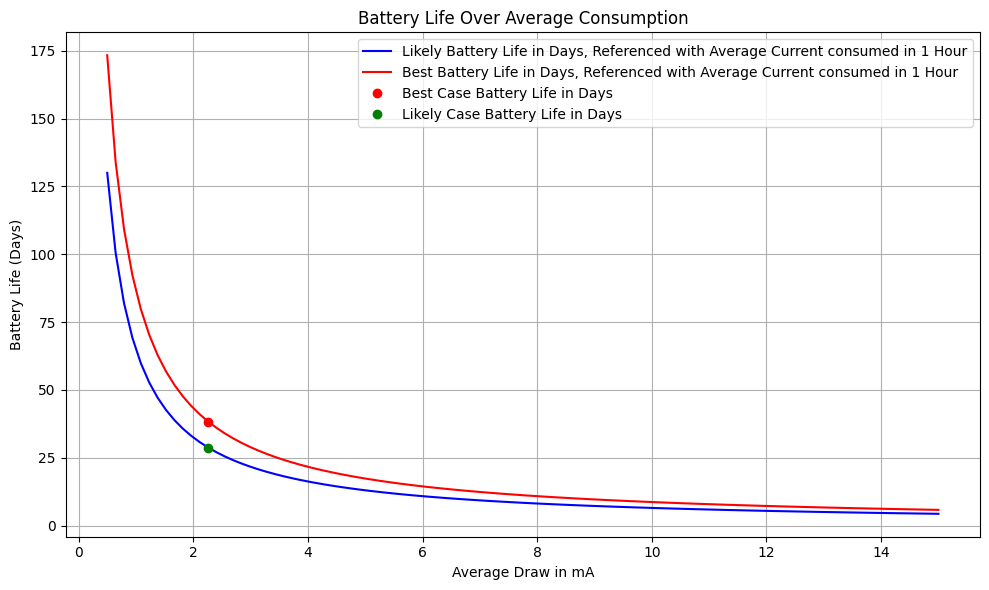

In [6]:
print("Let's verify the arrays first. First, the active draw over time. Then, the sleep draw over time.\n")
arrayprinter(power_array_active_time, 3)
arrayprinter(power_array_sleep_time, 3)
power_total_active_time = np.sum(power_array_active_time)
power_total_sleep_time = np.sum(power_array_sleep_time)
print("\nNow, let's calculate the total draw over time.")
print(f'The total active draw over time for one run is {power_total_active_time:.2f} mAh.')
print(f'The total sleep draw over time for one cycle is {power_total_sleep_time:.2f} mAh.')
average_power = (power_total_active_time + power_total_sleep_time) / (active_mode_time/(seconds_per_minute*minutes_per_hour) + deep_sleep_time/(seconds_per_minute*minutes_per_hour))
print(f'The average consumption is {(average_power):.2f} mA.\n')

# Let's compute the power budget over time in hours
# Formula: Estimated battery life = (Battery capacity in mAh) / (Total power consumption in mAh) * (1 - Safety margin)

best_case_battery_life = battery_capacity / (average_power) * (1.0 - battery_safety_margin)
likely_case_battery_life = (battery_capacity * 0.75) / (average_power) * (1.0 - battery_safety_margin)
print(f'The estimated "best case" battery life (accounting for 100% charge available, 20% safety margin) is,\n'
      f'{best_case_battery_life:.2f} hours, or {best_case_battery_life/24:.2f} days.')
# 6 hours of sleep, plus 0.0222 hours of active time (80 sec) per cycle
print(f'The estimated "likely case" battery life (accounting for 75% charge available, 20% safety margin) is,\n'
      f'{likely_case_battery_life:.2f} hours, or {likely_case_battery_life/24:.2f} days.\n')

# Let's plot the consumption over time
plt.figure(figsize=(10, 6))

x = np.linspace(0.5, 15, 100)# 100 cycles
z = ((battery_capacity)/(x) * (1.0 - battery_safety_margin))/24 * np.ones(100) # Best case battery life in days
y = ((battery_capacity*0.75)/(x) * (1.0 - battery_safety_margin))/24 * np.ones(100) # Likely case battery life in days
plt.plot(x, y, label='Likely Battery Life in Days, Referenced with Average Current consumed in 1 Hour', color='blue')
plt.plot(x, z, label='Best Battery Life in Days, Referenced with Average Current consumed in 1 Hour',color='red')
plt.plot(average_power, best_case_battery_life/24, 'ro', label='Best Case Battery Life in Days')
plt.plot(average_power, likely_case_battery_life/24, 'go', label='Likely Case Battery Life in Days')
plt.xlabel('Average Draw in mA')
plt.ylabel('Battery Life (Days)')
plt.title('Battery Life Over Average Consumption')
plt.legend()
plt.grid()
save_fig('theoretical_battery_life_over_average_consumption', tight_layout=True, fig_extension="png", resolution=300)
plt.show()

# Test2 Results

**_Post Test2 Analysis_**

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df_cloud_measurements = pd.read_csv('data.csv', sep=';', header=0)
#print(df_cloud_measurements.head())
print(df_cloud_measurements.describe())


             TDS       Temp  bootCounter   cycleTime         pH     rawTDS  \
count  57.000000  57.000000    57.000000   57.000000  57.000000  57.000000   
mean    4.519034  21.571820    29.000000   80.596491   5.230815  20.399386   
std     0.728692   0.770868    16.598193    3.954471   0.124191   0.672312   
min     2.173147  20.250000     1.000000   78.000000   4.936106  18.235000   
25%     4.080874  21.000000    15.000000   79.000000   5.174757  19.995130   
50%     4.642975  21.625000    29.000000   79.000000   5.242974  20.513740   
75%     5.010690  22.125000    43.000000   81.000000   5.303821  20.853000   
max     5.736579  23.312500    57.000000  101.000000   5.492078  21.522730   

       voltagePh  voltageTDS  
count  57.000000   57.000000  
mean    1.840013    0.045066  
std     0.019539    0.001309  
min     1.792500    0.041265  
25%     1.829250    0.044392  
50%     1.838625    0.045017  
75%     1.850625    0.045642  
max     1.882875    0.047830  


In [8]:
# Compute the number of cloud measurements
cloud_count = len(df_cloud_measurements)
print(f'The number of cloud measurements is {cloud_count}.\n')



The number of cloud measurements is 57.



In [9]:
df_sd_measurements = pd.read_csv('sd_data.csv', sep=';', header=0)
#print(df_sd_measurements.head())
print(df_sd_measurements.describe())

       finalTemp   finalTDS     rawTDS  voltageTDS    finalpH  voltagePh
count  57.000000  57.000000  57.000000   57.000000  57.000000  57.000000
mean   21.571404   4.519474  20.399123    0.046140   5.230702   1.840351
std     0.770789   0.729252   0.671444    0.004911   0.124037   0.019176
min    20.250000   2.170000  18.240000    0.040000   4.940000   1.790000
25%    21.000000   4.080000  20.000000    0.040000   5.170000   1.830000
50%    21.620000   4.640000  20.510000    0.050000   5.240000   1.840000
75%    22.120000   5.010000  20.850000    0.050000   5.300000   1.850000
max    23.310000   5.740000  21.520000    0.050000   5.490000   1.880000


In [10]:
# Compute the number of SD measurements
offline_count = len(df_sd_measurements) - cloud_count
print(f'The number of offline measurements is {offline_count}.\n')

The number of offline measurements is 0.



In [11]:
# Compute the percentage of cloud measurements
cloud_percentage = (cloud_count / (cloud_count + offline_count)) * 100
print(f'The percentage of cloud measurements is {cloud_percentage:.2f} %.\n')

# Compute the percentage of offline measurements
offline_percentage = (offline_count / (cloud_count + offline_count)) * 100
print(f'The percentage of offline measurements is {offline_percentage:.2f} %.\n')

The percentage of cloud measurements is 100.00 %.

The percentage of offline measurements is 0.00 %.



In [12]:
df_time = pd.read_csv('sd_time.csv', sep=';', header=0)
#print(df_time.head())
print(df_time.describe())

       completeCycleTime  cycleSeconds  cycleMinutes  cycleHours  \
count          57.000000     57.000000     57.000000   57.000000   
mean            0.244955  21164.105263    352.735088    5.878918   
std             0.033026   2853.425896     47.557098    0.792618   
min             0.000000      0.000000      0.000000    0.000000   
25%             0.249213  21532.000000    358.866667    5.981111   
50%             0.249306  21540.000000    359.000000    5.983333   
75%             0.249479  21555.000000    359.250000    5.987500   
max             0.249861  21588.000000    359.800000    5.996667   

       measurementCycle  
count         57.000000  
mean          79.175439  
std           11.383137  
min            0.000000  
25%           79.000000  
50%           79.000000  
75%           80.000000  
max          101.000000  


In [13]:
time_count = len(df_time)
print(f'The number of time measurements is {time_count}.\n')
print(f'The time measurement dataframe computes the time difference between two measurements.\n')

The number of time measurements is 57.

The time measurement dataframe computes the time difference between two measurements.



In [14]:
# drop all rows where the measurementCycle is less than 70 (deep sleep only happens 
# when measurements are uploaded)
df_time_filtered_sleep = df_time.drop(df_time[df_time["measurementCycle"] < 70].index)

df_time_filtered_sleep["deepSleepCycle"] = df_time_filtered_sleep["cycleSeconds"] - df_time_filtered_sleep["measurementCycle"]


print(df_time_filtered_sleep["deepSleepCycle"].describe())
print(f'The mean sleep time is {df_time_filtered_sleep["deepSleepCycle"].mean():.2f} seconds.\n')
print(f'The mean sleep time is {df_time_filtered_sleep["deepSleepCycle"].mean()/60:.2f} minutes.\n')
print(f'The mean sleep time is {df_time_filtered_sleep["deepSleepCycle"].mean()/3600:.2f} hours.\n')
print(f'The total sleep time is {df_time_filtered_sleep["deepSleepCycle"].sum():.2f} seconds.\n')
print(f'The total sleep time is {df_time_filtered_sleep["deepSleepCycle"].sum()/60:.2f} minutes.\n')
print(f'The total sleep time is {df_time_filtered_sleep["deepSleepCycle"].sum()/3600:.2f} hours.\n')
print(f'The total sleep time is {df_time_filtered_sleep["deepSleepCycle"].sum()/3600/24:.2f} days.\n')

count       56.000000
mean     21461.446429
std         25.211772
min      21321.000000
25%      21452.750000
50%      21461.500000
75%      21472.500000
max      21509.000000
Name: deepSleepCycle, dtype: float64
The mean sleep time is 21461.45 seconds.

The mean sleep time is 357.69 minutes.

The mean sleep time is 5.96 hours.

The total sleep time is 1201841.00 seconds.

The total sleep time is 20030.68 minutes.

The total sleep time is 333.84 hours.

The total sleep time is 13.91 days.



In [15]:
# We need to compute the total measurement time
measurement_time = df_time["measurementCycle"].sum()
print(f'The total measurement time is {measurement_time} seconds.\n')
print(f'The total measurement time is {measurement_time/60:.2f} minutes.\n')
print(f'The total measurement time is {measurement_time/3600:.2f} hours.\n')
print(f'The total measurement time is {measurement_time/21600:.2f} days.\n')

The total measurement time is 4513 seconds.

The total measurement time is 75.22 minutes.

The total measurement time is 1.25 hours.

The total measurement time is 0.21 days.



In [16]:
# We need to compute the total measurement time divided between uploaded measurements and offline measurements
measurement_time_cloud = df_cloud_measurements["cycleTime"].sum()
print(f'The total measurement time for cloud measurements is {measurement_time_cloud} seconds.\n')
print(f'The total measurement time for cloud measurements is {measurement_time_cloud/60:.2f} minutes.\n')
print(f'The total measurement time for cloud measurements is {measurement_time_cloud/3600:.2f} hours.\n')
print(f'The total measurement time for cloud measurements is {measurement_time_cloud/21600:.2f} days.\n')

# Print separator
print("--------------------------------------------------\n")
# We need to compute the total measurement time for offline measurements

df_measurement_time_offline = df_time.drop(df_time[df_time["measurementCycle"] > 70].index)
measurement_time_offline = df_measurement_time_offline["measurementCycle"].sum()
print(f'The total measurement time for offline measurements is {measurement_time_offline} seconds.\n')
print(f'The total measurement time for offline measurements is {measurement_time_offline/60:.2f} minutes.\n')
print(f'The total measurement time for offline measurements is {measurement_time_offline/3600:.2f} hours.\n')
print(f'The total measurement time for offline measurements is {measurement_time_offline/21600:.2f} days.\n')

The total measurement time for cloud measurements is 4594 seconds.

The total measurement time for cloud measurements is 76.57 minutes.

The total measurement time for cloud measurements is 1.28 hours.

The total measurement time for cloud measurements is 0.21 days.

--------------------------------------------------

The total measurement time for offline measurements is 0 seconds.

The total measurement time for offline measurements is 0.00 minutes.

The total measurement time for offline measurements is 0.00 hours.

The total measurement time for offline measurements is 0.00 days.



In [17]:
# Compute the total runtime (active + sleep)
total_runtime = df_time["cycleHours"].sum()
print(f'The total runtime is {total_runtime} hours.\n')
print(f'The total runtime is {total_runtime/24:.2f} days.\n')

The total runtime is 335.098333334 hours.

The total runtime is 13.96 days.



The top voltage is 4.2 V.

The actual starting voltage is 4.18 V.

The starting voltage percentage is 99.52 % of the max voltage.

The voltage decrease is 0.55 V.

The ending voltage is 3.63 V.

Assuming remaining capacity is approximately 25%.

The used capacity is 1950.0 mAh.

Total runtime is 335.098333334 hours.

The NEW estimated average power consumption is 5.82 mA.

The average estimated power consumption is 2.57 greater than the estimate.

--------------------------------------------------

The UPDATED estimated "best case" battery life (accounting for 100% charge available, 20% safety margin) is,
357.44 hours, or 14.89 days.
The UPDATED estimated "likely case" battery life (accounting for 75% charge available, 20% safety margin) is,
268.08 hours, or 11.17 days.



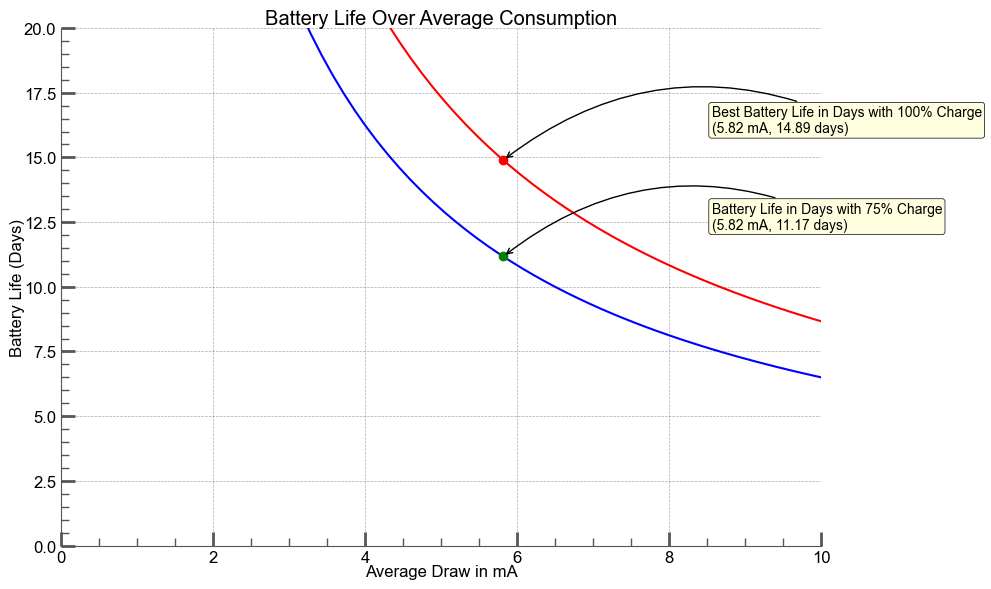

In [18]:
# Let's correct our battery life calculation

top_voltage = 4.2 # 4.2 V, 100% charge
print(f'The top voltage is {top_voltage} V.\n')
starting_voltage = 4.18 # 4.18 V, 100% charge
print(f'The actual starting voltage is {starting_voltage} V.\n')
starting_voltage_percent = starting_voltage / top_voltage * 100 # 99.52 %
print(f'The starting voltage percentage is {starting_voltage_percent:.2f} % of the max voltage.\n')
voltage_drop = 0.55 # 0.55 V, voltage drop after the measurement period
print(f'The voltage decrease is {voltage_drop} V.\n')
ending_voltage = starting_voltage - voltage_drop # 3.63 V
print(f'The ending voltage is {ending_voltage} V.\n')
print(f'Assuming remaining capacity is approximately 25%.\n')
used_capacity = 0.75 * battery_capacity
print(f'The used capacity is {used_capacity} mAh.\n')
print(f'Total runtime is {total_runtime} hours.\n')
average_current = used_capacity / total_runtime
print(f'The NEW estimated average power consumption is {average_current:.2f} mA.\n')
print(f'The average estimated power consumption is {average_current/average_power:.2f} greater than the estimate.\n')
average_power = average_current

# Print a separator
print("--------------------------------------------------\n")

# New estimate battery life calculation
# Let's compute the power budget over time in hours
# Formula: Estimated battery life = (Battery capacity in mAh) / (Total power consumption in mAh) * (1 - Safety margin)

best_case_battery_life = battery_capacity / (average_power) * (1.0 - battery_safety_margin)
likely_case_battery_life = (battery_capacity * 0.75) / (average_power) * (1.0 - battery_safety_margin)
print(f'The UPDATED estimated "best case" battery life (accounting for 100% charge available, 20% safety margin) is,\n'
      f'{best_case_battery_life:.2f} hours, or {best_case_battery_life/24:.2f} days.')
# 6 hours of sleep, plus 0.0222 hours of active time (80 sec) per cycle
print(f'The UPDATED estimated "likely case" battery life (accounting for 75% charge available, 20% safety margin) is,\n'
      f'{likely_case_battery_life:.2f} hours, or {likely_case_battery_life/24:.2f} days.\n')

# Let's plot the consumption over time
from aquarel import load_theme
theme = load_theme("scientific")
theme.apply()

plt.figure(figsize=(10, 6))

x = np.linspace(0.5, 15, 100)# 100 cycles
z = ((battery_capacity)/(x) * (1.0 - battery_safety_margin))/24 * np.ones(100) # Best case battery life in days
y = ((battery_capacity*0.75)/(x) * (1.0 - battery_safety_margin))/24 * np.ones(100) # Likely case battery life in days
plt.plot(x, y, label='Battery Life in Days (75% charge), Referenced with Average Current consumed in 1 Hour', color='blue')
plt.plot(x, z, label='Battery Life in Days (100% charge), Referenced with Average Current consumed in 1 Hour',color='red')
plt.plot(average_power, best_case_battery_life/24, 'ro', label='Best Case Battery Life in Days')
plt.plot(average_power, likely_case_battery_life/24, 'go', label='Worst Case Battery Life in Days')

# Annotations
important_points = [
    (average_power, likely_case_battery_life / 24, "Battery Life in Days with 75% Charge"),
    (average_power, best_case_battery_life / 24, "Best Battery Life in Days with 100% Charge"),
]

for x, y, label in important_points:
    plt.annotate(
        f'{label}\n({x:.2f} mA, {y:.2f} days)',
        xy=(x, y),
        xytext=(150, 20),  # Offset
        textcoords='offset points',
        fontsize=10,
        color='black',
        bbox=dict(boxstyle="round,pad=0.2", fc="lightyellow", ec="black", lw=0.5),
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.3")
    )

plt.xlabel('Average Draw in mA')
plt.ylabel('Battery Life (Days)')

# Set x and y limits
plt.xlim(0, 10)
plt.ylim(0, 20)
plt.xticks(fontsize=12)

plt.title('Battery Life Over Average Consumption')

# Set the grid and layout
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
#plt.legend()
save_fig('real_life_data_battery_life_over_average_consumption', tight_layout=True, fig_extension="png", resolution=300)
plt.show()

theme.apply_transforms()